# EnergyAnalysis Class
Calculate the solar supply, demand, storage left, and storage demand with given data of area (default as California)
...

## Import packages

In [1]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import h5pyd
import pickle #TEST

## Class implementation

### Energy Supply Analysis

In [2]:
class EnergySupplyAnalysis:
    '''
    The class for energy supply analysis for given capacity and GHI data

    Parameter
    ---------
    capacity: int
        Utility-scale solar power capacity
        unit: Mega Watts
    
    solarDataFile: str
        Solar data file path
    '''
    def __init__(self, f: h5pyd._hl.files.File, capacity=17500) -> None:
        assert isinstance(capacity, float) or isinstance(capacity, int)
        assert isinstance(f, h5pyd._hl.files.File)
        
        self.capacity = capacity
        dset = f['ghi']
        factor = f['ghi'].attrs['psm_scale_factor']
        self.__solarData = pd.DataFrame()
        self.__solarData['Date'] = pd.to_datetime(f['time_index'][...].astype(str))
        self.__solarData['GHI'] = dset / factor
        self.__solarData['Supply'] = self.__solarData['ghi'] * capacity / 1000.
    
    def getEnergySupply(self) -> pd.DataFrame:
        return self.__solarData

In [3]:
class EnergySupplyAnalysisCSV:
    '''
    The class for energy supply analysis for given capacity and GHI data

    Parameter
    ---------
    capacity: int
        Utility-scale solar power capacity
        unit: Mega Watts
    
    solarDataFile: str
        Solar data file path
    '''
    def __init__(self, capacity=17500, solarDataFile: str='../raw_data/midCalifornia_GHI.csv') -> None:
        assert isinstance(capacity, float) or isinstance(capacity, int)
        assert isinstance(solarDataFile, str)

        self.solarData = pd.read_csv(solarDataFile)
        self.capacity = capacity
        self.__energySupply()

    def __energySupply(self) -> pd.DataFrame:
        '''
        Calculate the supply with given solar and solar panel capacity data

        Returns
        -------
        pandas.DataFrame
            | Year | Month | Day | Hour | Minute | GHI | Supply |
            |------|-------|-----|------|--------|-----|--------|
        
            Year: int
            Month: int
            Day: int
            Hour: int
            Minute: int
            GHI: int
            Supply: float
        '''
        self.__supplyDF = self.solarData
        self.__supplyDF['Supply'] = self.__supplyDF['GHI'] * self.capacity / 1000
    
    def getEnergySupply(self) -> pd.DataFrame:
        return self.__supplyDF

### Energy Demand Analysis

In [4]:
class EnergyDemandAnalysis:
    '''
    The class for energy demand analysis for given electrical data

    Parameter
    ---------
    energyDataFile: str
        Electrical demand data file path
    '''
    def __init__(self, energyDataFile: str='../raw_data/CAISOactualLoad.csv') -> None:
        assert isinstance(energyDataFile, str)

        self.demandData = pd.read_csv(energyDataFile)
        self.__energyDemand()

    def __energyDemand(self) -> pd.DataFrame:
        '''
        Calculate the demand with electrical data

        Returns
        -------
        pandas.DataFrame
            | Date | Demand |
            |------|--------|
        
            Date: datetime
            Demand: float
        '''

        data = self.demandData[self.demandData['zone'] == 'CA ISO']
        data['date'] = pd.to_datetime(data['Date'])
        self.__demandDF = data[['date', 'load']]
        self.__demandDF = self.__demandDF.rename(columns={"date": "Date", "load": "Demand"})
    
    def getEnergyDemand(self) -> pd.DataFrame:
        return self.__demandDF

In [5]:
#Energy storage analysis:


class StorageAnalysis:
    """
        This class takes in a pandas dataframe in the form of 
            | date | hour | supply |
            |------|------|--------|
            and
            | date | hour | demand |
            |------|------|--------|

            and creates a dataframe in the form of:
            
            | date | hour | storage demand | storage supplied | storage Left | Curtailed supply |
            |------|------|----------------|------------------|--------------|------------------|

            where storage demand is the need for power that is not met by solar capacity,
            storage supplied is the amount of energy supplied that hour, which should equal demand unless storageLeft goes to zero.
            storageLeft is a the amount of energy left in the storage devices.

            Storage Demand: Supply - Demand. a positive number indicates the needed power beyond solar supply to meet demand
                            a negative number represents excess supply that ideally would be sent to storage.
            Storage Supplied: Actual power supplied by storage. Only differs from Storage Demand when the battery
                            empties or gets full.
            Storage Left: The current MWh stored in the grid
            Curtailed supply: Excess generation that was not able to be stored in the battery. Always positive or zero.
                                only positive when storage is full

            
    """
    def __init__(self, the_supply: pd.DataFrame, the_demand: pd.DataFrame, the_storageMWh: int):
        """
        Takes in dataframes for supply and demand in the format:
        | Year | Month | Day | Hour | Minute | ... | Supply | ... |
        |------|-------|-----|------|--------|-----|--------|-----|
        and 
        | Year | Month | Day | Hour | Minute | ... | Demand | ... |
        |------|-------|-----|------|--------|-----|--------|-----|
        both in MW and initilizes 

        self.storage_left: pd.Series[int]
        self.storage_demand: pd.Series[int]
        self.storage_supplied: pd.Series[int]
        self.curtailed_supply: pd.Series[int]
        

        Args:
            the_supply (pd.DataFrame): _description_
            the_demand (pd.DataFrame): _description_
            the_storageMWh (int): _description_
        """
        self.supplyDF = the_supply
        self.demandDF = the_demand
        self.storage_max = the_storageMWh

        self.supply: pd.Series[int] = self.supplyDF["Supply"]
        self.demand: pd.Series[int] = self.demandDF["Demand"] 
        self.sized_demand: pd.Series[int]
        self.storage_left: pd.Series[int]
        self.storage_demand: pd.Series[int]
        self.storage_supplied: pd.Series[int]
        self.curtailed_supply: pd.Series[int]
        self.total_supplied: pd.Series[int]
        self.supply_defecit: pd.Series[int]

        self.__set_storage_series()
        

    def __set_storage_series(self):
        """
        Sets pd.Series data so complete dataframe can be returned
        """
        #self.supply: pd.Series[float] 
        #print(the_supply)
        #self.demand: pd.Series[float] 
        #print(the_demand)
        #net_generation: pd.Series[float] = the_supply - the_demand 
        #print(net_generation)
        sized_demand_list: list[int] = [self.demand.iat[0]]
        storage_demand_list: list[int] = [self.demand.iat[0] - self.supply.iat[0]]
        storage_supplied_list: list[int] = [min(self.storage_max, self.demand.iat[0] - self.supply.iat[0])]
        storage_left_list: list[int] = [self.storage_max - storage_supplied_list[0]]
        curtailed_supply_list: list[int] = [max(0, storage_supplied_list[0] - storage_demand_list[0])]
        total_supplied_list: list[int] = [storage_supplied_list[0] + self.supply.iat[0]]
        supply_defecit_list: list[int] = [min(0,self.demand.iat[0] - total_supplied_list[0])]

        #Try doing this with something faster than for loop
        for i in range(1,len(self.supply)):
            net_storage_Demand: int = self.demand.iat[i] - self.supply.iat[i]

            #Setting sized demand:
            sized_demand_list.append(self.demand.iat[i])

            #getting storage demand, negative implies oversupply:
            storage_demand_list.append(net_storage_Demand)

            #getting storage left
            storage: int = storage_left_list[i-1] - net_storage_Demand
            if storage < 0:
                storage = 0
            elif storage > self.storage_max:
                storage = self.storage_max
            storage_left_list.append(storage)

            #getting storage supplied:
            if net_storage_Demand > 0:
                storage_supplied_list.append(min(storage_left_list[i-1], net_storage_Demand))
            else:
                storage_supplied_list.append(max(storage_left_list[i-1] - self.storage_max, net_storage_Demand))

            #getting curtailed supply:
            curtailed_supply_list.append(max(0, storage_supplied_list[i] - storage_demand_list[i]))

            #Getting total supplied:
            total_supplied_list.append(self.supply.iat[i] - curtailed_supply_list[i] + storage_supplied_list[i])

            #getting supply defecit:
            #supply_defecit_list.append(m(0, ))
            

        self.sized_demand = pd.Series(sized_demand_list)
        self.storage_left = pd.Series(storage_left_list)
        self.storage_demand = pd.Series(storage_demand_list)
        self.storage_supplied = pd.Series(storage_supplied_list)
        self.curtailed_supply = pd.Series(curtailed_supply_list)
        self.total_supplied = pd.Series(total_supplied_list)
        
    def get_storage_data(self):
        """
        

        Returns:
            Dataframe: | date | hour | storage demand | storage supplied | storage Left | Curtailed supply |
                       |------|------|----------------|------------------|--------------|------------------|

            where storage demand is the need for power that is not met by solar capacity,
            storage supplied is the amount of energy supplied that hour, which should equal demand unless storageLeft goes to zero.
            storageLeft is a the amount of energy left in the storage devices.

            Storage Demand: Supply - Demand. a positive number indicates the needed power beyond solar supply to meet demand
                            a negative number represents excess supply that ideally would be sent to storage.
            Storage Supplied: Actual power supplied by storage. Only differs from Storage Demand when the battery
                            empties or gets full.
            Storage Left: The current MWh stored in the grid
            Curtailed supply: Excess generation that was not able to be stored in the battery. Always positive or zero.
                                only positive when storage is full
        """
        return_dict = {"Total Demand" : self.sized_demand,
                       "Solar Supply" : self.supply,
                       "Storage Demand" : self.storage_demand,
                       "Storage Supplied" : self.storage_supplied,
                       "Storage Left" : self.storage_left,
                       "Curtailed Supply" : self.curtailed_supply,
                       "Total Supplied" : self.total_supplied
                       }
        
        return_dates = self.supplyDF[["Year","Month","Day","Hour"]]
        
        return pd.concat([return_dates, pd.DataFrame(return_dict)], axis=1)
        # print(self.storage_left)
        # print(self.storage_demand)
        # print(self.storage_supplied)
        # print(self.curtailed_supply)
    
    

#https://assessingsolar.org/notebooks/solar_power_modeling.html

## Test

In [6]:
f = h5pyd.File("/nrel/nsrdb/v3/nsrdb_2012.h5", 'r')

In [7]:
test = EnergySupplyAnalysisCSV()

In [8]:
test.getEnergySupply()
test_demand = EnergyDemandAnalysis()
test_demand.getEnergyDemand()

/tmp/ipykernel_12243/1616221536.py:31: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['date'] = pd.to_datetime(data['Date'])
/tmp/ipykernel_12243/1616221536.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['date'] = pd.to_datetime(data['Date'])


,Date,Demand
1,2018-01-01 00:00:00,21202.0
12,2018-01-01 01:00:00,20559.0
23,2018-01-01 02:00:00,20017.0
34,2018-01-01 03:00:00,19629.0
45,2018-01-01 04:00:00,19613.0
...,...,...
390213,2020-12-31 19:00:00,25789.0
390230,2020-12-31 20:00:00,24974.0
390247,2020-12-31 21:00:00,24128.0
390264,2020-12-31 22:00:00,23102.0


In [9]:
#California average energy use: ~29 GWh per hour
#California average power: 29 GW
#Using capacity factor of 25%, Solar capacity needs to be at least 116 GW
#using 1.5 times needed solar, we have 164 GW
#24 hours of storage is 696 GWh
#https://www.energy.gov/sites/prod/files/2015/05/f22/CA-Energy%20Sector%20Risk%20Profile.pdf
test_supply = EnergySupplyAnalysisCSV(164000)
test_demand = EnergyDemandAnalysis()
test_storage = StorageAnalysis(test_supply.getEnergySupply(), test_demand.getEnergyDemand(), 696000)
#print(test_storage.demand)
#print(test_storage.supply)
#pd.set_option("display.max_rows",100)
results = test_storage.get_storage_data()
test_storage.get_storage_data()
    


#https://assessingsolar.org/notebooks/solar_power_modeling.html

/tmp/ipykernel_12243/1616221536.py:31: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['date'] = pd.to_datetime(data['Date'])
/tmp/ipykernel_12243/1616221536.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['date'] = pd.to_datetime(data['Date'])


,Year,Month,Day,Hour,Total Demand,Solar Supply,Storage Demand,Storage Supplied,Storage Left,Curtailed Supply,Total Supplied
0,2018,1,1,0,21202.0,4100.0,17102.0,17102.0,678898.0,0.0,21202.0
1,2018,1,1,1,20559.0,0.0,20559.0,20559.0,658339.0,0.0,20559.0
2,2018,1,1,2,20017.0,0.0,20017.0,20017.0,638322.0,0.0,20017.0
3,2018,1,1,3,19629.0,0.0,19629.0,19629.0,618693.0,0.0,19629.0
4,2018,1,1,4,19613.0,0.0,19613.0,19613.0,599080.0,0.0,19613.0
...,...,...,...,...,...,...,...,...,...,...,...
26275,2020,12,31,19,21279.0,83476.0,-62197.0,-62197.0,148834.0,0.0,21279.0
26276,2020,12,31,20,22489.0,84788.0,-62299.0,-62299.0,211133.0,0.0,22489.0
26277,2020,12,31,21,24493.0,76096.0,-51603.0,-51603.0,262736.0,0.0,24493.0
26278,2020,12,31,22,26594.0,58384.0,-31790.0,-31790.0,294526.0,0.0,26594.0


<Figure size 576x360 with 0 Axes>

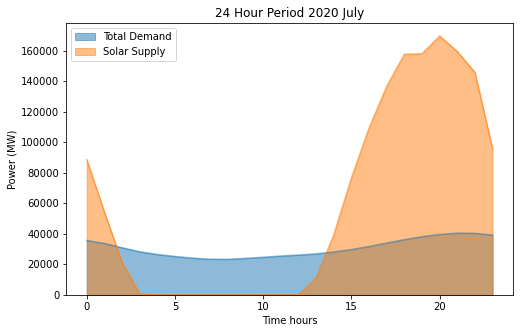

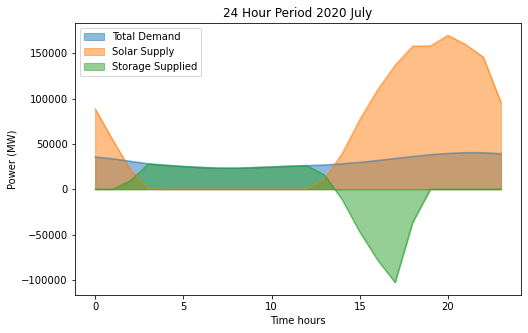

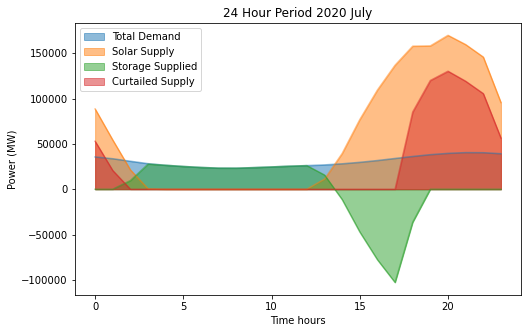

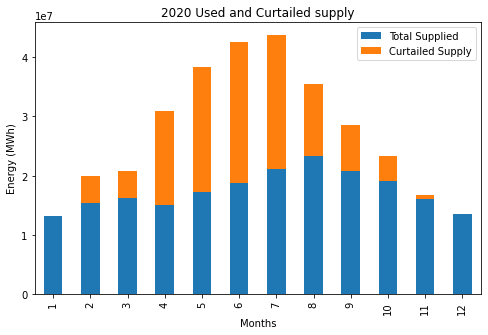

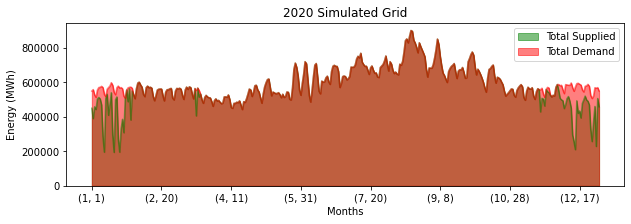

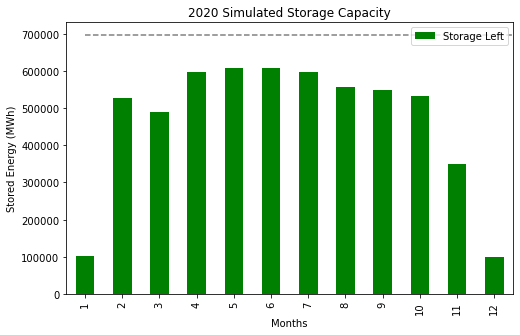

In [10]:
plt.rcParams["figure.figsize"] = (8, 5)
plt.figure()
# plt.plot(df_year_load['Date'].tolist(), df_year_load['load'].tolist())
#TEST start
global analysisYear_ref
analysisYear_ref = 2020
results_2020 = results.loc[results['Year'] == analysisYear_ref]

global analysisYear
analysisYear = results_2020['Year'].iloc[0]
#TEST end

results_July_2020 = results_2020.loc[results['Month'] == 7]
results_July_10_2020 = results_July_2020.loc[results_July_2020["Day"] == 10]
results_monthly = results_2020.groupby([ "Month"]).sum()
results_daily = results_2020.groupby(["Month", "Day"]).sum()
results_monthly_mean = results_2020.groupby(["Month"]).mean()
results_daily_mean = results_2020.groupby(["Month", "Day"]).mean()

#results_July_2020.plot()
results_July_10_2020.plot(x ="Hour", y=["Total Demand", "Solar Supply", ], kind="area", stacked=False)
plt.xlabel('Time hours')
plt.ylabel('Power (MW)')
plt.title('24 Hour Period 2020 July')
#TEST start
global hours24_1
hours24_1 = 1
#TEST end

results_July_10_2020.plot(x ="Hour", y=["Total Demand", "Solar Supply", "Storage Supplied"], kind="area", stacked=False)
plt.xlabel('Time hours')
plt.ylabel('Power (MW)')
plt.title('24 Hour Period 2020 July')
#TEST start
global hours24_2
hours24_2 = 1
#TEST end

results_July_10_2020.plot(x ="Hour", y=["Total Demand", "Solar Supply", "Storage Supplied","Curtailed Supply"], kind="area", stacked=False)
plt.xlabel('Time hours')
plt.ylabel('Power (MW)')
plt.title('24 Hour Period 2020 July')
#TEST start
global hours24_3
hours24_3 = 1
#TEST end

#results_July_10_2020.plot(y=["Curtailed Supply", "Solar Supply", "Storage Left"], secondary_y="Storage Left", kind="area", stacked=False)
#plt.xlabel('Time hours')
#plt.ylabel('Power (MW)')
#plt.title('24 Hour Period 2020 July')
#results_July_10_2020.plot(subplots=[("Total Demand", "Solar Supply", "Storage Supplied"), ("Storage Left", "Curtailed Supply")], kind="area", stacked=False)
results_monthly.plot( y=["Total Supplied", 'Curtailed Supply'], kind="bar", stacked=True)
plt.xlabel('Months')
plt.ylabel('Energy (MWh)')
plt.title('2020 Used and Curtailed supply')
#TEST start
global used_curtailed
used_curtailed = 1
#TEST end
#results_monthly.plot( y=["Total Supplied", 'Total Demand'], kind="bar", stacked=False)
results_daily.plot(y=["Total Supplied", 'Total Demand'], kind="area", stacked=False, color=["green", "red"], figsize=(10,3))
plt.xlabel('Months')
plt.ylabel('Energy (MWh)')
plt.title('2020 Simulated Grid')
#TEST start
global grid
grid = 1
#TEST end
#results_2020.plot.hexbin(x="Storage Left", y="Total Demand", gridsize=20)
#results_daily.plot(y='Curtailed Supply', kind="area", stacked=False)
results_monthly_mean.plot(y="Storage Left", kind="bar", color="green")
#results_daily_mean.plot(y="Storage Left")


#results.plot(y="Storage Left")
#results_2018["Total Supplied", ]
plt.hlines(696000, xmin=0, xmax=12, linestyles='dashed',colors='grey', label='Maximum storage level')
plt.xlabel('Months')
plt.ylabel('Stored Energy (MWh)')
plt.title('2020 Simulated Storage Capacity')
#TEST start
global storageCapacity
storageCapacity = 1
#TEST end

In [11]:
#TEST start
with open('analysisVars.pkl', 'wb') as f:
    pickle.dump([analysisYear_ref, analysisYear, hours24_1, hours24_2, hours24_3, used_curtailed, grid, storageCapacity], f)
#TEST end